In [328]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import *
import pickle 
import random
from time import sleep
import json
import requests
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.cluster import KMeans, MiniBatchKMeans
from nltk.tokenize import RegexpTokenizer

In [2]:
#отключение предупреждений
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [ ]:
groups = pd.read_csv('ekb_community_stats.csv', header=None).values.ravel().tolist()

Для анализа было решено использовать часть данных, так как доступные мне вычислительные мощности не позволяют обрабатывать все предоставленные данные. Подвыборка выбиралась случайно.

In [ ]:
subsample_size = 20000
rand_groups = []
for i in range(subsample_size):
    group = random.choice(groups)
    rand_groups.append(group)
    groups.remove(group)  

In [ ]:
pickle.dump(rand_groups, open( "rand_groups_origin", "wb" ))
wall_get()

In [ ]:

def wall_get(id):
    """
    Keyword arguments:
    id - group's id
    
    returns [0] if error
    otherwise reterns [number of posts in group, last 100 posts]
    """
    first = "https://api.vk.com/method/wall.get?owner_id=-"
    last = "&count=100"
    data = requests.get(first + str(id) + last)
    datas = data.content.decode('utf8')
    data = json.loads(datas)
    try:
        data = data['response']
    except:
        return [0]
    return data[0], data[1:]

# Загрузка данных

В некоторых группах из выборки контент представлен в виде картинок. Было решено разделить группы, где информация передается с помощью картинок и где информация передается с помощью текста. Часть групп из воборки представляет собой закрытые, заблокированные сообщества, а так же сообщества, в которых недостаточно информации для анализа (мало постов). Такие группы удалялись. 

* av_word_len - средняя длина слова
* pic_groups_list - список идентификаторов групп с картинками
* text_groups_list список идентификаторов групп с текстом
* deleted_groups - список идентификаторов удаленных групп
* text_groups_dict словарь, содержащий список из постов групп. Ключем является идентефикатор группы

In [ ]:
"""av_word_len = 7
pic_groups_list = []
text_groups_list = []
text_groups_dict = {}
deleted_groups = []

j = 0"""

for id in rand_groups:

    posts = wall_get(id)
    
    
    if posts[0] <= 15: #если мало постов, удаляем группу
        j += 1
        deleted_groups.append(id)
        continue
      
    if posts[0] < 100: 
        n_posts = posts[0]
    else:
        n_posts = 100
    group_posts = []
    group_len = 0
    
    for post in posts[1]:
        new_post = ' '.join(post['text'].split('<br>'))
        group_len += len(new_post)
        group_posts.append(new_post)
    
    if float(group_len) / (n_posts * av_word_len) < 6.5: #Если количество слов на пост в группе < 6.5, добавляем в pic
        pic_groups_list.append(id)
    else:
        text_groups_dict[str(id)] = group_posts
        text_groups_list.append(id)
    
    j += 1
    print(j, id)


In [149]:
"""Во время загрузки данных у меня отключился интернет, 
которого не было в последствии весь день, поэтому для 
анализа использовалось меньше групп, чем указано выше."""

len(text_groups_list), len(pic_groups_list), len(deleted_groups)

(8082, 1474, 3434)

In [ ]:
#Сохранение данных
pickle.dump(deleted_groups, open( "deleted_groups", "wb" ))
pickle.dump(pic_groups_list, open( "pic_groups_list", "wb" ))
pickle.dump(text_groups_list, open( "text_groups_list", "wb" ))
pickle.dump(text_groups_dict, open( "text_groups_dict", "wb" ))

# Кластеризация групп с текстом

Для кластеризации групп с текстом было решено использовать алгоритм K-means. Все посты были лемматизированы. После, все посты из одной группы были склеены в один текст. После данные были преобразованы с помощью алгоритма tf-idf.

## Получение матрицы признаков

Для получения матрицы признаков можно использовать разные подходы. Далее будут опробованы два из них:

* tf-idf
* doc2vec

Но прежде, чем давать алгоритмам данные, их нужно обработать.

## Обработка данных

In [ ]:
#Лемматизация
m = Mystem()
keys = list(text_groups_dict.keys())
j = 0

for key in keys:
    for i in range(len(text_groups_dict[key])):
        text_groups_dict[key][i] = ''.join(m.lemmatize(text_groups_dict[key][i]))
    j += 1
    print(j, key)

In [ ]:
#Сохранение данных
pickle.dump(text_groups_dict, open( "text_groups_dict_lem", "wb" ))

In [ ]:
#Склейка всех постов в каждой группе
text_group_dict2 = {}
for key in keys:
    text_group_dict2[key] = ''.join((''.join(text_groups_dict[key])).split("\n"))       
        

In [ ]:
#Сохранение данных
pickle.dump(text_group_dict2, open( "text_group_dict_lem2", "wb" ))

In [3]:
#Загрузка данных
data_dict = pickle.load(open('text_group_dict_lem2', 'rb'))
data = list(data_dict.values())

In [4]:
#Загрузка стоп слов
file = open("stop_words.txt", encoding='utf-8')
stop_words = file.read().split("\n")
file.close()

In [171]:
# Токенизация и удаление стоп слов
tokenizer = RegexpTokenizer(r'\w+')
tokenized_data = {}

for key in data_dict:
    tokens = tokenizer.tokenize(data_dict[key])
    stopped_tokens = [i for i in tokens if not i in stop_words]
    tokenized_data[key] = stopped_tokens

pickle.dump(tokenized_data, open('lemmatized_tokenized_text', 'wb'))

In [264]:
tokenized_data = pickle.load(open('lemmatized_tokenized_text', 'rb'))

## doc2vec

In [11]:
from gensim import corpora, models
from gensim.models import doc2vec
from collections import namedtuple


dictionary = corpora.Dictionary(list(tokenized_data.values()))
corpus = [dictionary.doc2bow(text) for text in list(tokenized_data.values())]



In [12]:
docs = []
docs_labels = list(tokenized_data.keys())
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, words in enumerate(list(tokenized_data.values())):
    tags = [i]
    docs.append(analyzedDocument(words, tags))

In [13]:
doc_model = doc2vec.Doc2Vec(documents=docs, window=10)

In [21]:
for i in range(5):
    rand_group = random.randint(0, 8083)
    print('-----------------\n', rand_group, 'vk.com/club' + docs_labels[rand_group])
    print(*np.array(doc_model.similar_by_vector(doc_model.docvecs[rand_group], topn=4))[:,0])
    print('-----------------\n2 most similar groups:\n')
    top_n = doc_model.docvecs.most_similar(rand_group, topn=2)
    for i in top_n:
        ind = int(i[0])
        print(i[0], 'vk.com/club' + docs_labels[i[0]], i[1], 
              *np.array(doc_model.similar_by_vector(doc_model.docvecs[ind], topn=4))[:,0])


-----------------
 596 vk.com/club53503880
просто мочь хотеть бояться
-----------------
2 most similar groups:

3295 vk.com/club43005314 0.5198018550872803 просто думать значит любить
7116 vk.com/club50101397 0.4754263758659363 заставлять нихера размышлять успех
-----------------
 655 vk.com/club10285494
оборотень разбойник криминальный грабитель
-----------------
2 most similar groups:

5690 vk.com/club36647917 0.7694495916366577 оборотень приключение похищать чудовище
1872 vk.com/club42788054 0.758505642414093 оборотень барри криминальный детектив
-----------------
 1687 vk.com/club41293763
Neurohop Glitch glitchhop idm
-----------------
2 most similar groups:

2215 vk.com/club51207325 0.7073994278907776 The Hill Remix From
1296 vk.com/club19492084 0.6798967719078064 The Remix Hill photographed
-----------------
 6651 vk.com/club79580527
ресничка длинныересница ламинирование ресница
-----------------
2 most similar groups:

2408 vk.com/club21885045 0.6392230987548828 ресница ресничка

In [22]:
doc2vec_matrix = np.array(doc_model.docvecs)

## tf-idf


In [23]:
vectorizer = TfidfVectorizer(
            max_df=0.5,
            max_features=5000,
            min_df=2,
            stop_words=stop_words,
            analyzer="word")

In [25]:
#Преобразование данных с помощью tf-idf
tf_matrix = vectorizer.fit_transform(data)
tf_matrix = tf_matrix.toarray()
keys = list(data_dict.keys())

# Кластеризация

## K-means + tf-idf

Алгоритм K-means требует входным параметром количество кластеров. Один из подходов определения количества кластеров - это Elbow Method. Для его реализации необходимо посчитать SSE для некоторого количества кластеров.
$$SSE = \sum_{k=1}^K \sum_{{x_i \in C_k}}dist(x_i, \mu_k)^2$$, где $C_k$ - это k-ый кластер, а $\mu_k$ - его центр.

Идея в том, чтобы найти кластер, на котором сумма квадратов ошибок начнет снижаться незначительно.

In [ ]:
# Посчитаем k-means с разным количеством кластеров
km_dict = {}

for num_clust in range(2, 250):
    km = KMeans(n_clusters=num_clust, n_init=1)
    km.fit(tf_matrix)
    km_dict[num_clust] = km

In [228]:
# Посчитаем ошибку для каждой реализации k-means
k_means_sse = []
for key in km_dict:
    k_means_sse.append(compute_sse(tf_matrix,km_dict[key].labels_, km_dict[key].cluster_centers_)) 

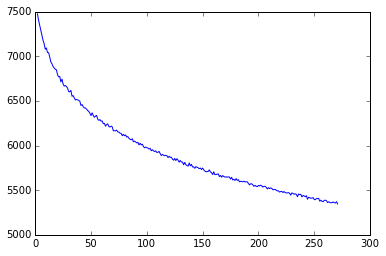

In [229]:
# Построим график
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(list(km_dict.keys()), k_means_sse)
plt.show()

К сожалению, по графику выше не получается определить количество кластеров. 
Тем не менее, убедимся, что подход с k-means работает на кластеризации текстов. Возьмем количество кластеров равным 50.

In [234]:
n_clusters = 50
km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1)
                         

In [235]:
km.fit(tf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=50, n_init=1, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [238]:
terms = vectorizer.get_feature_names()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

print("Ключевые слова по кластерам: \n")
for i in range(n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Ключевые слова по кластерам: 

Cluster 0: отношение энергия мысль деньги любовь сила цель женщина твой книга
Cluster 1: бизнес сайт клиент компания деньги товар реклама интернет пользователь продажа
Cluster 2: доход зарабатывать выплата рубль интернет график заработок требоваться проект руб
Cluster 3: игра сервер игрок играть игровой обновление клан онлайн разработчик ip
Cluster 4: vkontakte добавляться вступать руб рубль сайт екатеринбург вконтакте голос photo
Cluster 5: фильм сериал жанр сезон серия комедия режиссер роль драма актер
Cluster 6: добавлять взаимно ава лайка взаимный заявка подписчик го кидать лайк
Cluster 7: трек альбом песня клип рэп музыка релиз сингл ep feat
Cluster 8: букет цветок роза заказ растение цветочный невеста свадьба доставка свадебный
Cluster 9: член секс см оргазм goo gl парень кончать рубль сантиметр
Cluster 10: фотограф фотосессия съемка фотография фотосъемка свадебный фотостудия студия свадьба модель
Cluster 11: екатеринбург конкурс фестиваль программа

Как можно заметить, k-means довольно неплохо справляется с кластеризацией текста. Кластеры, полученные с помощью такого подхода вполне можно назвать тематическими. Тем не менее, сложность заключается в выборе кластеров. Поставив слишком большое количество кластеров, мы можем получить повторяющиеся кластеры, а поставив маленькое, можем не получить важной информации.

# Иерархическая кластеризация с помощью k-means

Для того, чтобы устранить недостаток, описанный выше, было решено запустить k-means делить данные рекурсивно по два кластера. Таким образом можно построить дерево, в узлах которой будут данные о конкретных кластерах. Критерием остановки будет служить максимальный размер кластера (max_cl_size). Если кластер меньше максимального размера кластера, то происходит выход из рекурсии. Выбор максимального размера кластера зависит от конкретизации, которую требуется получить. Можно поставить изначально низкое значение, так как всегда есть возможность подняться на уровень выше.

Данные о кластерах:

* data - векторы, полученные из матрицы X
* level - глубина дерева, на которой лежит кластер
* size - размер кластера
* words - ключевые слова кластера
* groupd - идентефикаторы групп кластера
* center - центр кластера

Позже, для каждого кластера будет добавлено еще одно поле:

* ind - индекс кластера на определенной глубине


In [ ]:
def get_clust_words(k_means, ind, num=10):
    """
    Keyword arguments:
    k_means - k-means object
    ind - cluster's index
    num - numbers of words to return
    
    returns num ind-th cluster's key words
    """
    terms = vectorizer.get_feature_names()
    order_centroids = k_means.cluster_centers_.argsort()[:, ::-1]
    
    words = []
    for i in order_centroids[ind, :num]:
        words.append(terms[i])
    return words


def recurent_km(data, groups, cluster_words=None, center=None, max_cl_size=400, k=1, stage=0):    
    global max_level
    if stage == 0:
        max_level = 0
    if max_level < stage:
        max_level = stage
    clust_dict = {}
    clust_dict['data'] = data
    clust_dict['level'] = stage
    clust_dict['size'] = len(data)
    clust_dict['words'] = cluster_words
    clust_dict['groups'] = groups
    clust_dict['center'] = center
    
    
    if len(data) < max_cl_size:
        list_tree[k-1] = clust_dict
        return
    
    list_tree[k-1] = clust_dict
    
    km = KMeans(n_clusters=2, init='k-means++', n_init=1)
    
    km.fit(data) 
    data1 = []
    data2 = []
    groups1 = []
    groups2 = []
    center1 = km.cluster_centers_[0]
    center2 = km.cluster_centers_[1]
    cluster_words1 = get_clust_words(km, 0)
    cluster_words2 = get_clust_words(km, 1)
    
    labels = km.labels_
    for i in range(len(labels)):
        if labels[i] == 0:
            data1.append(data[i])
            groups1.append(groups[i])
        else:
            data2.append(data[i])
            groups2.append(groups[i])
    recurent_km(data=data1, groups=groups1, cluster_words=cluster_words1, center=center1, k=2*k, stage=stage+1)
    recurent_km(data=data2, groups=groups2, cluster_words=cluster_words2, center=center2, k=2*k + 1, stage=stage+1)

list_num = 2**23
list_tree = [0] * list_num      #лист, куда будут записываться кластера (взят с запасом)
max_cl_size = 400               #максимальный размер кластера
groups = list(data_dict.keys()) # идентефикаторы групп
recurent_km(data=tf_matrix, groups=groups)

In [253]:
print("Глубина дерева:", max_level)

Глубина дерева: 15


In [72]:
#Разделение на уровни и присвоение каждому кластеру индекса

levels = []

for i in range(max_level + 2):
    levels.append(list_tree[(2**i)-1: 2**(i+1) - 1])

for level in levels[1:]:
    for i in range(len(level)):
        if level[i] != 0:
            level[i]['ind'] = level.index(level[i])

In [64]:
#Нахождение конечных кластеров
down_cl = []
for level in levels[1:]:
    for cluster in level:
        if cluster != 0:
            if cluster['size'] < max_cl_size:
                down_cl.append(cluster)

Получив дерево кластеров, можно посмотреть на конечные кластеры (кластеры, размер которах не превышает max_cl_size) и решить, удовлетворяют ли эти кластерам заданным требованиям. Если конечные кластеры можно разделить на подклассы, то следует запустить алгоритм, уменьшив max_cl_size. Если конечные кластеры повторяют друг друга, можно, с помощью вспомогательной функции получить их родителя.

In [105]:
def get_ancestor(cluster):
    """
    Keyword arguments:
    cluster - cluster's data from list_tree
    
    returns cluster's ancestor
    """
    level = levels[cluster['level'] - 1]
    ind = cluster['ind'] // 2
    
    return level[ind] 

def sort_groups(cluster):
     """
    Keyword arguments:
    cluster - cluster's data from list_tree
    
    returns sorted by the distance frome the center groups
    """
    center = cluster['center']
    groups = cluster['groups']
    data = cluster['data']
    dist_matrix = []
    sorted_groups = []
    for vec in data:
        dist_matrix.append(euclidean(vec, center))
    sorted_ind = np.array(dist_matrix).argsort()
    for ind in sorted_ind:
        sorted_groups.append(groups[ind])
    return sorted_groups
    

Ниже можно увидеть для каждого кластера его размер, глубину на которой он находится, его индекс и ключевые слова

In [255]:
print("Количество коечных кластеров:",len(down_cl), '\n')

for i in down_cl:
    print(i['size'], i['level'], i['ind'], *i['words'])

Количество коечных кластеров: 42 

395 2 1 свадьба свадебный невеста фотограф фотосессия съемка wedding прическа макияж платье
7 3 4 утро слабо осень ночь сердце твой верить музыка спокойный любовь
204 3 6 книга фильм бог история земля любовь женщина смерть жанр сила
205 4 3 масло мышца сахар упражнение яйцо ложка тренировка соль добавлять ингредиент
15 4 10 бог божий господь любовь молитва преподобный иоанн твой христос святой
138 4 14 малыш вода масло мама ложка организм кожа упражнение сахар добавлять
330 4 15 деньги женщина мужчина бизнес отношение цель энергия книга любовь проблема
142 5 0 секс искать парень познакомиться член вирт анон привет встреча куни
251 5 2 руб iphone чехол apple samsung продавать рубль размер смартфон наличие
140 6 6 платье наличие размер заказ цвет руб ткань одежда юбка скидка
383 6 9 квартира сайт компания интернет рубль доход зарабатывать бизнес руб проект
267 6 10 концерт билет альбом песня музыка фестиваль клуб рок екатеринбург москва
149 6 11 альбом 

Как можно заметить, следующие кластера очень похожи между собой, поэтому мы можем посмотреть на их предка

* 240 6 44 твой любовь душа сердце никто скучать рядом счастие прощать уходить"
* 239 6 45 твой любовь мужчина женщина сердце счастие душа счастливый глаз никто

In [101]:
print(*get_ancestor(levels[6][44])['words'])
print(*get_ancestor(levels[6][45])['words'])

твой любовь сердце душа мужчина счастие женщина никто рядом счастливый
твой любовь сердце душа мужчина счастие женщина никто рядом счастливый


Ниже предоставлены ключевые слова по каждому кластеру и по 3 группы, наиболее приближенные к центру кластера


In [110]:
for cluster in down_cl:
    groups = sort_groups(cluster)
    print(*cluster['words'])
    print('\nvk.com/club' + groups[0])
    print('vk.com/club' + groups[1])
    print('vk.com/club' + groups[2], '\n')
    

свадьба свадебный невеста фотограф фотосессия съемка wedding прическа макияж платье

vk.com/club32768467
vk.com/club24251666
vk.com/club34752316 

утро слабо осень ночь сердце твой верить музыка спокойный любовь

vk.com/club30790069
vk.com/club46837498
vk.com/club45192348 

книга фильм бог история земля любовь женщина смерть жанр сила

vk.com/club51682933
vk.com/club45270133
vk.com/club18206367 

масло мышца сахар упражнение яйцо ложка тренировка соль добавлять ингредиент

vk.com/club54725864
vk.com/club48946342
vk.com/club32455286 

бог божий господь любовь молитва преподобный иоанн твой христос святой

vk.com/club16838988
vk.com/club29599237
vk.com/club36825554 

малыш вода масло мама ложка организм кожа упражнение сахар добавлять

vk.com/club82274301
vk.com/club54616802
vk.com/club42082503 

деньги женщина мужчина бизнес отношение цель энергия книга любовь проблема

vk.com/club54087668
vk.com/club47211280
vk.com/club51563246 

секс искать парень познакомиться член вирт анон привет в

## k-means + doc2vec

В данном подходе метрикой для k-means будет служить cosine similarity. В библиотеке sklearn нет возможности изменить метрику в этом алгоритме, поэтому воспользуемся реализацией k-means из библиотеки nltk.

In [239]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer

NUM_CLUSTERS = 50
k_means_doc2vec = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
k_means_doc2vec_labels = k_means_doc2vec.cluster(doc2vec_matrix, assign_clusters=True)
centroids_doc2vec_50 = k_means_doc2vec.means()

In [274]:
centroids_doc2vec_50 = k_means_doc2vec.means()

In [297]:
k_means_doc2vec_clust = {i: [] for i in range(len(set(k_means_doc2vec_labels)))}
for i in range(len(k_means_doc2vec_labels)):
    k_means_doc2vec_clust[k_means_doc2vec_labels[i]].append(i)

In [314]:
for i, centroid in enumerate(centroids_doc2vec_50):
    print(i, *np.array(doc_model.similar_by_vector(centroid, topn=10))[:,0])

0 картошечка рулька рис яичница кнель яйцо мясо овсянка молоко изюм
1 кожа осветление мазь маска бальзам увлажнять антивозрастный бледность актовегин скипидарный
2 платье костюмчик туника юбочка кардиган жакет кофточка одежда блузка пальто
3 подарок конкурс розыгрыш приз викторина викторин подарочек разыгрывать заказедаCesare фотоконкурс
4 осветление окрашивание смывка славянскиеволосый завивка здоровыеволосый Kapous волос Estel COCOCHOCO
5 na ot pochemu gde pri samye mozhet dlya chem po
6 Dropbox сервис продвижение маркетинговый контент сторонний MyGenetics лендинг Hulu провайдер
7 годовалый собачка собака котенок малыш щенок мама малышка ребенок кормить
8 облицовывать отделка фанера деревянный металлический фасад гипсокартон газобетон конструкция кровля
9 PARTY Gadyshev Pub NIGHT club6078485 DJ SPECIAL ALEX пати MACHINE
10 доипосле дизайнноготь радищева6а 89617709777 бровиновосибирск маникюр красивыеноготь BROW тайскийсалон кератинированиересница
11 ярмак id49891849 Megadeth бастый т

## Иерархическая кластеризация

In [330]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

class linkage_cluser:
    def __init__(self, data, keys, method='complete', pd_metric='euclidean', metric='euclidean'):
        self.data = data
        self.keys = keys
        self.method = method
        self.pd_metric = pd_metric
        self.metric = metric
        self.dist_matrix = squareform(pdist(data, metric=pd_metric))
        self.linkage_matrix = linkage(self.dist_matrix, method=method, metric=metric)
    
    def get_clusters(self, clusternum):
        clustdict = {i:[i] for i in range(len(self.linkage_matrix)+1)}
        for i in range(len(self.linkage_matrix)-clusternum+1):
            clust1= int(self.linkage_matrix[i][0])
            clust2= int(self.linkage_matrix[i][1])
            clustdict[max(clustdict)+1] = clustdict[clust1] + clustdict[clust2]
            del clustdict[clust1], clustdict[clust2]
        return clustdict

    def get_labels(self, clusternum):
        labels = [0] * len(self.data)
        clusters = self.get_clusters(clusternum)
        for clust in clusters:
            for i in clusters[clust]:
                labels[i] = clust
                
        lab_dict = dict(zip(list(set(labels)), range(len(set(labels)))))

        for i in range(len(labels)):
            labels[i] = lab_dict[labels[i]]
        return labels
    
    def get_centers(self, clusternum):
        centers = []
        clusters = self.get_clusters(clusternum)
        for clust in clusters:
            center = np.zeros(self.data.shape[1])
            for i in clusters[clust]:
                center += self.data[i]
            center /= len(clusters[clust])
            centers.append(center)
        return centers

In [331]:
linkage_tf_complete = linkage_cluser(data=tf_matrix, keys=keys, method='complete',
                                     pd_metric='euclidean',metric='euclidean')

In [334]:
linkage_tf_single = linkage_cluser(data=tf_matrix, keys=keys, method='single',
                                     pd_metric='euclidean',metric='euclidean')

# Кластеризация групп с картинками

Изначально, мной была допущена ошибка, из-за которой лист pic_groups_list записались группы, содержащие музыку. Ниже группы из pic_groups_list были разделены на music (группы с музыкой) и pic (группы с картинками).

Первый кластер (music) можно объеденить с аналогичным кластеров (кластер, ключевыми словами которого являются музыкальные жанры). Второй же (pic) было решено оставить, так как анализ картинок - довольно трудоемкая задача, которая, в контексте данного задания, не принесет большой пользы.

In [245]:
def get_wall2(id):
    first = "https://api.vk.com/method/wall.get?owner_id=-"
    last = "&count=100"
    data = requests.get(first + str(id) + last)
    datas = data.content.decode('utf8')
    data = json.loads(datas)
    try:
        data = data['response']
    except:
        data = 0
    return data

In [ ]:
pic = []
music = []
bad_id = []
j = 0
for id in pic_groups_list:
    wall = get_wall2(id)
    audio = 0
    if wall == 0:
        bad_id.append(id)
    else:
        for i in range(2, len(wall) - 2):
            try:
                attachments =  wall[i]['attachments']
                for attach in attachments:
                    try:
                        _ = attach['audio']
                        audio += 1
                    except:
                        continue 
            except:
                continue
                
        if audio/(len(wall) - 2) < 1:
            pic.append(id)
        else:
            music.append(id)

In [256]:
print(len(music), len(pic))

109 1364


In [185]:
def compute_sse(data, labels, centers):
    sse = 0
    for i in range(len(labels)):
        sse += euclidean(centers[labels[i]], data[i])**2
    return sse
            

In [219]:
sse_link = []
for j in range(2, 20):
    centers = []
    clusters = linkage_tf_complete.get_clusters(j)
    labels = linkage_tf_complete.get_labels(j)

    lab_dict = dict(zip(list(set(labels)), range(len(set(labels)))))


    for i in range(len(labels)):
        labels[i] = lab_dict[labels[i]]
    for clust in clusters:
        center = np.zeros(tf_matrix.shape[1])
        for i in clusters[clust]:
            center += tf_matrix[i]
        center /= len(clusters[clust])
        centers.append(center)
    centers = np.array(centers)
    sse = compute_sse(tf_matrix, labels, centers)
    sse_link.append(sse)
    print(j, sse)


2 8682.782172330739
3 8473.11596597136
4 7422.494930494605
5 7354.567027833694
6 7635.465378991153
7 7582.596952806747
8 7720.839507341633
9 7705.661574729696


KeyboardInterrupt: 

In [217]:
list(range(5,50,10))

[5, 15, 25, 35, 45]

In [212]:
labels = linkage_tf_complete.get_labels(300)
len(set(labels))

300